# KNMI Drought Analysis: SPI & SPEI

In [1]:
# This is a good source, which actually tests the fit of empirical data in relation to different distributions!

# Default used in literature is Gamma, but here also Weibull, Exponential and log-normal were tested. 

# https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml

In [2]:
# Also give credits to: https://www.numpyninja.com/post/how-to-implement-mice-algorithm-using-iterative-imputer-to-handle-missing-values 
# for a great Python-based MICE example that I could develop further on

In [3]:
import copy
import datetime
import numpy as np
import pandas as pd
import scipy.stats as scs

In [4]:
import knmi_meteo_ingest
import knmi_meteo_transform
import mice_imputation_utils

In [5]:
# Select station code
STN_CODE = 260

In [6]:
# Get station details for chosen code (sanity check)
stations_raw = knmi_meteo_ingest.knmi_load_meteo_stations()

# Show details of chosen station (should be non-empty)
stn = stations_raw[stations_raw["STN"] == STN_CODE].to_dict(orient="list")

# Assert error with message with valid options if station code not valid
valid_stns_str = ", ".join(str(x) for x in stations_raw["STN"])
err_msg = f"Invalid station code (integer) - valid options: {valid_stns_str}."

assert len(stn["NAME"]) > 0, err_msg

# Show details of chosen station
print(stn)

{'STN': [260], 'LON(east)': [5.18], 'LAT(north)': [52.1], 'ALT(m)': [1.9], 'NAME': ['De Bilt']}


In [7]:
# Get daily precipiation data from KNMI web script service
df_rainlist_y = []

year_start = 1901
year_end = 2024

for year in range(year_start, year_end+1):
    df_rain_y = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=[STN_CODE],
                                                   meteo_params_list=["RH"],
                                                   start_date=datetime.date(year, 1, 1),
                                                   end_date=datetime.date(year, 12, 31),
                                                   mode="day")
    
    df_rainlist_y.append(df_rain_y)

In [8]:
# Concatenate each non-empty yearly series to full history
# Note: use 'ignore_index' to deduplicate indexes from yearly DataFrames
df_rain_raw = pd.concat([df for df in df_rainlist_y if not df.empty],
                        ignore_index=True)

In [9]:
# Show the result
df_rain_raw

,STN,YYYYMMDD,RH
0,260,19010101,NaN
1,260,19010102,NaN
2,260,19010103,NaN
3,260,19010104,NaN
4,260,19010105,NaN
...,...,...,...
45286,260,20241227,0.0
45287,260,20241228,0.0
45288,260,20241229,7.0
45289,260,20241230,2.0


In [10]:
# Apply transformations to clean the raw dataset
df_rain = knmi_meteo_transform.transform_param_values(df_rain_raw)

In [11]:
# Cut off leading and trailing NaNs from history dataset
# In this way we get our actual historical start and end dates
min_idx = df_rain[["rain_sum"]].apply(pd.Series.first_valid_index).max()
max_idx = df_rain[["rain_sum"]].apply(pd.Series.last_valid_index).min()
df_rain = df_rain.loc[min_idx: max_idx, :]

In [12]:
# Show the result
df_rain

,station_code,date,rain_sum
1826,260,1906-01-01,0.000
1827,260,1906-01-02,0.000
1828,260,1906-01-03,0.000
1829,260,1906-01-04,3.600
1830,260,1906-01-05,13.400
...,...,...,...
45286,260,2024-12-27,0.000
45287,260,2024-12-28,0.000
45288,260,2024-12-29,0.700
45289,260,2024-12-30,0.200


In [13]:
# Now, re-index DataFrame so that it:
# 1. Always start at first day of the first month found
first_date = df_rain["date"].iloc[0]
last_date = df_rain["date"].iloc[-1]
target_first_date = datetime.date(year=first_date.year, 
                                  month=first_date.month, 
                                  day=1)

# 2. Always end on last day of last month found
target_last_date = (datetime.date(year=(last_date.year + (last_date.month // 12)),
                                  month=(last_date.month % 12) + 1,
                                  day=1) 
                                  - datetime.timedelta(days=1))

print(target_first_date, target_last_date)

1906-01-01 2024-12-31


In [14]:
# 3. Missing indexes in the range should be filled with NaNs!
full_month_index = pd.date_range(target_first_date, target_last_date, freq="D")

# Set range of collected non-NaN dates as initial index
df_rain.index = pd.to_datetime(df_rain["date"])

# Reindex to full months
df_rain = df_rain.reindex(full_month_index)

In [15]:
# Show the result
df_rain

,station_code,date,rain_sum
1906-01-01,260,1906-01-01,0.000
1906-01-02,260,1906-01-02,0.000
1906-01-03,260,1906-01-03,0.000
1906-01-04,260,1906-01-04,3.600
1906-01-05,260,1906-01-05,13.400
...,...,...,...
2024-12-27,260,2024-12-27,0.000
2024-12-28,260,2024-12-28,0.000
2024-12-29,260,2024-12-29,0.700
2024-12-30,260,2024-12-30,0.200


In [16]:
# Remove station code and "incomplete" date column
drop_cols = ["date", "station_code"]
df_rain = df_rain.loc[:,~df_rain.columns.isin(drop_cols)]

# Rename full-month index to "date"
df_rain = df_rain.rename_axis(index="date")
df_rain

,rain_sum
date,
1906-01-01,0.000
1906-01-02,0.000
1906-01-03,0.000
1906-01-04,3.600
1906-01-05,13.400
...,...
2024-12-27,0.000
2024-12-28,0.000
2024-12-29,0.700


<Axes: title={'center': 'De Bilt (260) - Daily precipitation [mm]'}, xlabel='date'>

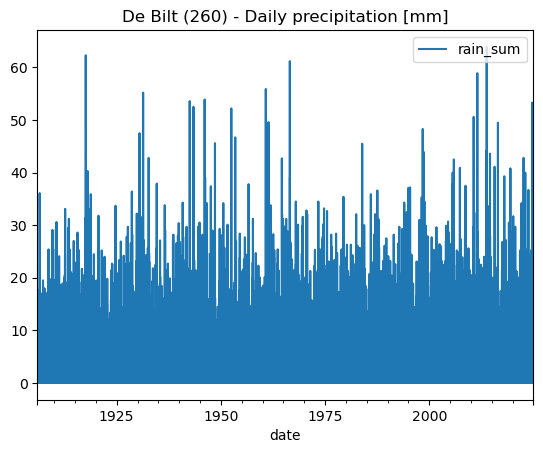

In [17]:
df_rain.plot(title=f"{stn["NAME"][0]} ({stn["STN"][0]}) - Daily precipitation [mm]")

In [18]:
# Convert full date into column for Grouper
if df_rain.index.name == "date":
    df_rain = df_rain.reset_index()

df_rain

,date,rain_sum
0,1906-01-01,0.000
1,1906-01-02,0.000
2,1906-01-03,0.000
3,1906-01-04,3.600
4,1906-01-05,13.400
...,...,...
43460,2024-12-27,0.000
43461,2024-12-28,0.000
43462,2024-12-29,0.700
43463,2024-12-30,0.200


In [19]:
agg_func = pd.NamedAgg(column=df_rain.columns[-1],
                       aggfunc=lambda x: 100.0 * np.mean(np.isnan(x)))
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_grouped = df_rain.groupby(grouper_obj).agg(result=agg_func)

In [20]:
df_rain_grouped["month"] = df_rain_grouped.index.month
df_rain_grouped["year"] = df_rain_grouped.index.year

df_rain_monthpivot = df_rain_grouped.pivot_table(index="year", columns="month", values="result")

In [21]:
with pd.option_context('display.max_rows', None,):
   print(df_rain_monthpivot.round(1))

month   1    2    3      4    5    6    7    8    9    10   11   12
year                                                               
1906   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1907   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1908   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1909   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1910   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1911   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1912   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1913   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1914   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1915   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1916   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1917   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1918   0.0  0.0  0.0    0.0  0.0  0.0  0.0  0.0 

In [22]:
# Find years to run imputation procedure for
df_rain_grouped[df_rain_grouped["result"] > 0]

,result,month,year
date,,,
1945-04-01,100.0,4,1945


In [23]:
# NOTE: Method below will not work (well) if all years in your dataset have almost 100% missing data;
# you should use multiple years of data in those cases, but logic for this edge scenario is not written here; implement yourself if needed!
# If you have a relatively long history of data anyway, you can also consider dropping that year outright

In [24]:
# Find unique years to run imputation for
years_to_impute = df_rain_grouped[df_rain_grouped["result"] > 0]["year"].tolist()
years_to_impute = list(set(years_to_impute))
years_to_impute.sort()

print(years_to_impute)

[1945]


In [25]:
try_impute = False
df_implist_y = []

if len(years_to_impute) > 0:
    # Get rain data of all stations for years to impute for
    try_impute = True

    for year in years_to_impute:
        df_imp_y = knmi_meteo_ingest.knmi_meteo_to_df(meteo_stns_list=None,
                                                      meteo_params_list=["RH"],
                                                      start_date=datetime.date(year, 1, 1),
                                                      end_date=datetime.date(year, 12, 31),
                                                      mode="day")
    
        df_implist_y.append(df_imp_y)

In [26]:
# Concatenate each non-empty yearly series to full history
# Note: use 'ignore_index' to deduplicate indexes from yearly DataFrames
if try_impute:
    if len(df_implist_y) > 0:
        df_imp_raw = pd.concat([df for df in df_implist_y if not df.empty],
                                ignore_index=True)

In [27]:
if try_impute:
    # Apply transformations to clean the raw dataset
    df_imp = knmi_meteo_transform.transform_param_values(df_imp_raw)

    # Show the result
    print(df_imp)

      station_code        date  rain_sum
0              235  1945-01-01       NaN
1              235  1945-01-02       NaN
2              235  1945-01-03       NaN
3              235  1945-01-04       NaN
4              235  1945-01-05       NaN
...            ...         ...       ...
1820           380  1945-12-27       NaN
1821           380  1945-12-28       NaN
1822           380  1945-12-29       NaN
1823           380  1945-12-30       NaN
1824           380  1945-12-31       NaN

[1825 rows x 3 columns]


In [28]:
if try_impute:
    # Pivot data with 'date' as index, 'stn_code' as cols
    df_imp_pivot = (df_imp.pivot(index="date",
                                 columns="station_code"))

    # Flatten pivot table to single index
    df_imp_pivot.columns = (df_imp_pivot.columns
                            .get_level_values(1))
    
    # Show the result
    print(df_imp_pivot)

station_code  235   260  280  310  380
date                                  
1945-01-01    NaN   0.1  NaN  NaN  NaN
1945-01-02    NaN   0.0  NaN  NaN  NaN
1945-01-03    NaN   1.8  NaN  NaN  NaN
1945-01-04    NaN   1.9  NaN  NaN  NaN
1945-01-05    NaN   0.2  NaN  NaN  NaN
...           ...   ...  ...  ...  ...
1945-12-27    NaN   4.4  NaN  NaN  NaN
1945-12-28    NaN  19.9  NaN  NaN  NaN
1945-12-29    NaN   0.2  NaN  NaN  NaN
1945-12-30    NaN   0.1  NaN  NaN  NaN
1945-12-31    NaN   0.1  NaN  NaN  NaN

[365 rows x 5 columns]


In [29]:
# Sort all stations on correlation with target station
# The station itself will have a value of 1 (by definition)
if try_impute:
    corr_scores = (df_imp_pivot
                   .corrwith(df_imp_pivot[STN_CODE])
                   .sort_values(ascending=False))
    print(corr_scores)

station_code
260    1.0
235    NaN
280    NaN
310    NaN
380    NaN
dtype: float64


In [30]:
run_impute = False

if try_impute:
    # Find up to N best-correlating stations for imputation years
    # Note: less stations will be used in case of empty results
    nr_impute_stns = 5

    # Drop NaNs from the correlation scores
    corr_scores = corr_scores[~corr_scores.isna()]

    # Get maximum index (minimum of N and non-NaN corr elements)
    max_corr_idx = min(1 + nr_impute_stns, len(corr_scores))
    impute_stn_codes = corr_scores[1 : max_corr_idx].index.tolist()

    # Print warning message in case of all-NaN correlations
    warn_msg = ("No matching stations found for MICE imputation; use "
               "another method or drop missing data instead of imputing.")
    if len(impute_stn_codes) == 0:
        print(warn_msg)
        run_impute = False
    else:
        run_impute = True

    # If all OK, print external station codes to use for imputation
    print(impute_stn_codes)

No matching stations found for MICE imputation; use another method or drop missing data instead of imputing.
[]


In [31]:
print(run_impute)

False


In [32]:
if run_impute:
    # Define colums to keep for imputation calculation
    keep_cols = [STN_CODE] + impute_stn_codes

    # Apply column filter
    df_imp_sel = df_imp_pivot.loc[:, df_imp_pivot.columns.isin(keep_cols)]

    # Ensure that our target impute column is always the first
    df_imp_sel = df_imp_sel[[STN_CODE] + impute_stn_codes]

    # Get maximum value from imp. dataset; no imp. value should be larger
    max_imp_val = np.nanmax(df_imp_sel.values)

    # Show the result (table with data to use for imputation)
    print(df_imp_sel)

In [33]:
from sklearn.linear_model import (LinearRegression, Ridge, 
                                  Lasso, BayesianRidge)
from sklearn.ensemble import (RandomForestRegressor, 
                              GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

# Note: IterativeImputer is still experimental; import as such
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

In [34]:
if run_impute:
    # Set random seed value at 42 for result reproducibility
    r_seed = 42
    np.random.seed(r_seed)
 
    full_data = df_imp_sel.dropna(subset=[STN_CODE])
    incomplete_data = full_data.copy()

    # Introduce missingness in target column (here: 25% of values missing at random)
    missing_mask = np.random.rand(incomplete_data.shape[0]) < 0.25
    incomplete_data.loc[missing_mask, STN_CODE] = np.nan

    # Test values are only present in the "full_data" overview
    test_vals = full_data.loc[missing_mask, STN_CODE].to_numpy()

    # Set base imputer
    base_imputer = IterativeImputer(max_iter=30, tol=1e-6, min_value=0,
                                    max_value=max_imp_val, random_state=r_seed,
                                    imputation_order="roman")

    # Set model scoring emphasis (RMSE versus R^2)
    alpha = 0.5

    # Define the models and their parameter grids
    models_and_params = {
        "LinearRegression":
            (LinearRegression(), {}),
        "Ridge": (
            Ridge(),
            {
            "alpha": [0.1, 1.0, 10.0]
            }
        ),
        "Lasso": (
            Lasso(),
            {
            "alpha": [0.001, 0.01, 0.1, 1.0, 10.0]
            }
        ),
        "Random Forest": (
            RandomForestRegressor(random_state=r_seed),
            {
            "n_estimators": [10, 20, 50, 100],
            "max_depth": [3, 5, 7, 10]
            }
        ),
        "GradientBoostingRegressor": (
            GradientBoostingRegressor(random_state=r_seed),
            {
            "n_estimators": [50, 100, 200],
            "learning_rate": [0.01, 0.05, 0.1],
            "max_depth": [3, 5, 7, 10]
            },
        ),
        "BayesianRidge": (
            BayesianRidge(),
            {
            "alpha_1": [1e-6, 1e-5],
            "alpha_2": [1e-6, 1e-5],
            "lambda_1": [1e-6, 1e-5],
            "lambda_2": [1e-6, 1e-5],
            },
        ),
        "KNeighborsRegressor": (
            KNeighborsRegressor(),
            {
            "n_neighbors": [3, 5, 7],
            "weights": ["uniform", "distance"],
            },
        ),
    }

    # Initialize variables to track the best model and its performance
    best_model_name = None
    best_params = None
    best_score = float("inf")
    best_imputer = None

    # Loop through each model and parameter grid
    for model_name, (model, param_grid) in models_and_params.items():
        print(f"Testing model: {model_name}")
    
        # Iterate through all parameter combinations
        for params in ParameterGrid(param_grid):
            # Create a new estimator with the current parameters
            estimator = model.set_params(**params)
        
            # Set up the imputer with this estimator
            imputer = base_imputer.set_params(estimator=estimator)
        
            # Fit the imputer on the incomplete data
            imputed_data = imputer.fit_transform(incomplete_data)
        
            # Calculate the MSE and R^2 for the imputed values
            mse = mean_squared_error(
                test_vals,
                imputed_data[missing_mask, 0].round(3))

            r2 = r2_score(
                test_vals,  
                imputed_data[missing_mask, 0].round(3))
        
            # Combine the RMSE and R^2 into a single score
            score = alpha * np.sqrt(mse) - (1 - alpha) * (1 - r2)
        
            # print(f"  Params: {params}, MSE: {mse:.4f}, R^2: {r2:.4f}, score: {score:.4f}")
        
            # Update the best model if this is the best scoring one
            if score < best_score:
                best_score = score
                best_params = params
                best_model_name = model_name
                best_imputer = copy.deepcopy(imputer)

    # Print the best model and parameters
    print("\nBest Model and Parameters:")
    print(f"  Model: {best_model_name}")
    print(f"  Parameters: {best_params}")
    print(f"  Best score: {best_score:.4f}")

    # Use the best imputer for further imputation if needed
    final_imputed_data = best_imputer.transform(incomplete_data)

    # Calculate (R)MSE and R^2 for the best model
    final_mse = mean_squared_error(
        test_vals, # True values
        final_imputed_data[missing_mask, 0]) # Imputed values
    final_rmse = np.sqrt(final_mse)

    final_r2 = r2_score(
        test_vals,  # True values
        final_imputed_data[missing_mask, 0],  # Imputed values
    )

    print(f"  Imputation MSE: {final_mse:.4f}")
    print(f"  Imputation RMSE: {final_rmse:.4f}")
    print(f"  Imputation R^2: {final_r2:.4f}")

In [37]:
import mice_imputation_utils

if run_impute:
    (best_imputer, best_res, df_imp_filled_test) = mice_imputation_utils.fit_best_df_imputer_on_targetcol(df_imp_sel, STN_CODE)

    print(df_imp_filled_test)

In [38]:
if run_impute:
    print(df_imp_sel)

In [39]:
if run_impute:
    # Now fit and run the best imputer on the FULL to-impute dataset
    df_imputed = pd.DataFrame(data=best_imputer.fit_transform(df_imp_sel),
                              columns=df_imp_sel.columns,
                              index=df_imp_sel.index)

    # Only keep imputed values that were missing in dataset
    df_imputed["init_val"] = df_imp_sel[STN_CODE]
    df_imputed = df_imputed[df_imputed["init_val"].isna()]
    df_imputed = df_imputed.loc[:, [STN_CODE]]

    # Convert index type to DateTime
    df_imputed.index = pd.to_datetime(df_imputed.index)

    # Rename columns and reset 'date' col; show the result
    df_imputed = (df_imputed
                  .rename(columns={STN_CODE: "rain_sum_imputed"})
                  .reset_index())

    print(df_imputed)

In [40]:
if run_impute:
    # Merge imputed data with measured data if imputation was run
    df_rain_all = df_rain.merge(df_imputed, how="left", on="date").round(2)
else:
    # If no missing data were found, only add all-NaN imputation column
    df_rain_all = df_rain.copy()
    df_rain_all["rain_sum_imputed"] = np.nan

df_rain_all

,date,rain_sum,rain_sum_imputed
0,1906-01-01,0.000,NaN
1,1906-01-02,0.000,NaN
2,1906-01-03,0.000,NaN
3,1906-01-04,3.600,NaN
4,1906-01-05,13.400,NaN
...,...,...,...
43460,2024-12-27,0.000,NaN
43461,2024-12-28,0.000,NaN
43462,2024-12-29,0.700,NaN
43463,2024-12-30,0.200,NaN


In [67]:
print(f"Values in original dataset: {df_rain_all["rain_sum"].notna().sum()}"
      f"\nValues in imputed dataset: {df_rain_all["rain_sum_imputed"].notna().sum()}")

Values in original dataset: 43435
Values in imputed dataset: 0


In [68]:
df_rain_all

,date,rain_sum,rain_sum_imputed,is_imputed,rain_sum_all
0,1906-01-01,0.000,NaN,False,0.000
1,1906-01-02,0.000,NaN,False,0.000
2,1906-01-03,0.000,NaN,False,0.000
3,1906-01-04,3.600,NaN,False,3.600
4,1906-01-05,13.400,NaN,False,13.400
...,...,...,...,...,...
43460,2024-12-27,0.000,NaN,False,0.000
43461,2024-12-28,0.000,NaN,False,0.000
43462,2024-12-29,0.700,NaN,False,0.700
43463,2024-12-30,0.200,NaN,False,0.200


<Axes: xlabel='date'>

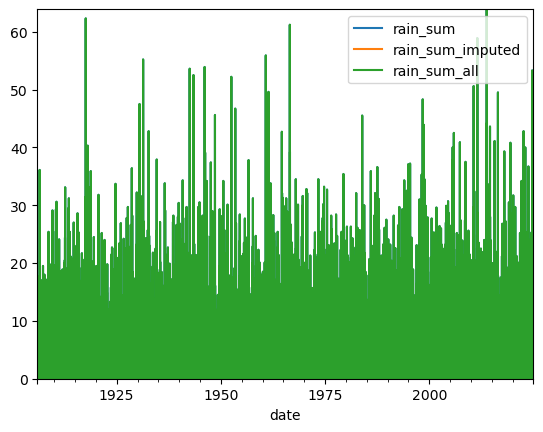

In [70]:
y_max = np.nanmax(df_rain_all.set_index("date").values)
df_rain_all.set_index("date").plot(ylim=(0, y_max))

/Users/Shared/anaconda3/envs/tom-ds/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Axes: ylabel='Frequency'>

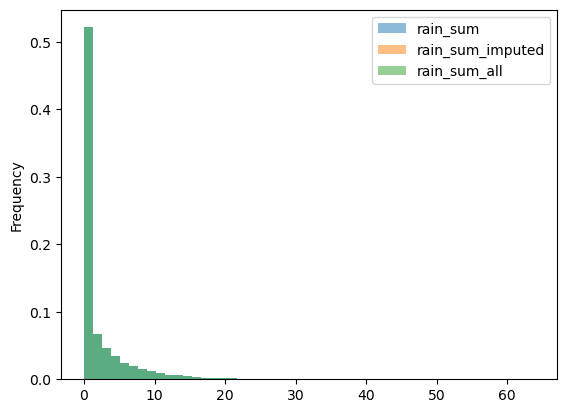

In [71]:
df_rain_all.set_index("date").plot(kind="hist", bins=50, density=True, alpha=0.5)

/Users/Shared/anaconda3/envs/tom-ds/lib/python3.12/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


<Axes: ylabel='Frequency'>

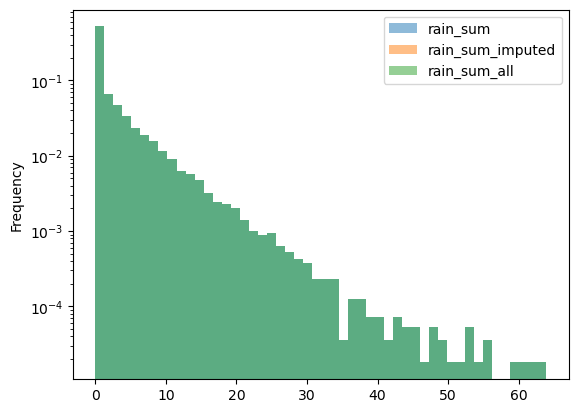

In [72]:
df_rain_all.set_index("date").plot(kind="hist", density=True, 
                                   alpha=0.5, logy=True, bins=50)

In [103]:
# Now, continue with the SPI analysis

In [73]:
# Keep track of fact whether data was imputed or not
df_rain_all["is_imputed"] = (df_rain_all["rain_sum"].isna() 
                             & ~df_rain_all["rain_sum_imputed"].isna())

# Create a fully-filled column with mixed real and imp. values
# Start by filling the column with the originally measured data
df_rain_all["rain_sum_all"] = df_rain_all["rain_sum"].copy()

# Fill the "_all" column with imputed data wherever applicable
filter_idxs = df_rain_all[df_rain_all["rain_sum_all"].isna()].index
df_rain_all.loc[filter_idxs, "rain_sum_all"] = df_rain_all["rain_sum_imputed"].copy()

df_rain_all

,date,rain_sum,rain_sum_imputed,is_imputed,rain_sum_all
0,1906-01-01,0.000,NaN,False,0.000
1,1906-01-02,0.000,NaN,False,0.000
2,1906-01-03,0.000,NaN,False,0.000
3,1906-01-04,3.600,NaN,False,3.600
4,1906-01-05,13.400,NaN,False,13.400
...,...,...,...,...,...
43460,2024-12-27,0.000,NaN,False,0.000
43461,2024-12-28,0.000,NaN,False,0.000
43462,2024-12-29,0.700,NaN,False,0.700
43463,2024-12-30,0.200,NaN,False,0.200


In [74]:
# Only keep parameter column and imputation label (yes/no)
keep_cols = ["date", "rain_sum_all", "is_imputed"]
df_rain_sel = df_rain_all[keep_cols]

df_rain_sel

,date,rain_sum_all,is_imputed
0,1906-01-01,0.000,False
1,1906-01-02,0.000,False
2,1906-01-03,0.000,False
3,1906-01-04,3.600,False
4,1906-01-05,13.400,False
...,...,...,...
43460,2024-12-27,0.000,False
43461,2024-12-28,0.000,False
43462,2024-12-29,0.700,False
43463,2024-12-30,0.200,False


In [77]:
# Set aggregation rules; any aggregate that still has any NaN(s) 
    # in its value is summed to NaN as a whole (prevent dist-fit errors)
lambda_sum_func = lambda x: np.nan if x.isnull().any() else x.sum()
agg_dict = {"rain_sum_all": lambda_sum_func,
            "is_imputed": "mean"}

In [78]:
# Aggregate dataset to months
grouper_obj = pd.Grouper(key="date", freq="MS")
df_rain_m_gr = (df_rain_sel
                .groupby(grouper_obj)
                .agg(agg_dict))

df_rain_m_gr

,rain_sum_all,is_imputed
date,,
1906-01-01,112.400,0.0
1906-02-01,53.400,0.0
1906-03-01,49.300,0.0
1906-04-01,29.500,0.0
1906-05-01,88.800,0.0
...,...,...
2024-08-01,40.625,0.0
2024-09-01,156.250,0.0
2024-10-01,43.250,0.0


In [79]:
# Test: use rolling window for N months
N = 3
df_rain_sums = df_rain_m_gr.rolling(window=N).agg(agg_dict)

df_rain_sums

,rain_sum_all,is_imputed
date,,
1906-01-01,NaN,NaN
1906-02-01,NaN,NaN
1906-03-01,215.100,0.0
1906-04-01,132.200,0.0
1906-05-01,167.600,0.0
...,...,...
2024-08-01,185.225,0.0
2024-09-01,284.875,0.0
2024-10-01,240.125,0.0


In [53]:
df_rain_sums["1945-01-01":"1946-01-01"]

,rain_sum_all,is_imputed
date,,
1945-01-01,317.2,0.0
1945-02-01,200.8,0.0
1945-03-01,143.8,0.0
1945-04-01,NaN,0.0
1945-05-01,NaN,0.0
1945-06-01,NaN,0.0
1945-07-01,215.2,0.0
1945-08-01,238.7,0.0
1945-09-01,276.4,0.0


In [54]:
# Time for fitting a distribution! 

# We will need (just as in: https://journals.ametsoc.org/view/journals/apme/53/10/jamc-d-14-0032.1.xml):
# 1. Gamma distribution function (note: totals should be nonzero!)
# 2. Exponential distribution function
# 3. Lognormal distribution function
# 4. Weibull distribution function
dist_names = ["gamma", "expon", "lognorm", "weibull_min"]

df_distr = pd.DataFrame()
df_distr["rain_sum"] = df_rain_sums["rain_sum_all"].copy()

# Just to make sure: set any total of 0 mm to 0.1 mm (to avoid zero-issues with gamma)
# Note: in arid regions, this may not suffice for a good fit
filter_idxs = df_distr[df_distr["rain_sum"] == 0.0].index
df_distr[df_distr.loc[filter_idxs, "rain_sum"]] = 0.1

# Get PDFs and CDFs for each best-fit distribution (using Max. Likelihood Est.)
for dist_name in dist_names:
    dist = getattr(scs, dist_name)

    params = dist.fit(df_distr["rain_sum"].dropna(), method="mle", loc=0)
    
    df_distr[dist_name + "_cdf"] = dist.cdf(df_distr["rain_sum"], *params)
    df_distr[dist_name + "_pdf"] = dist.pdf(df_distr["rain_sum"], *params)

In [55]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf
date,,,,,,,,,
1906-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1906-03-01,215.100,0.613861,0.005253,0.661012,0.002013,0.614711,0.005304,0.592951,0.005171
1906-04-01,132.200,0.158297,0.004322,0.445441,0.003293,0.156292,0.004279,0.172776,0.004027
1906-05-01,167.600,0.341633,0.005784,0.550565,0.002668,0.339628,0.005826,0.338731,0.005206
...,...,...,...,...,...,...,...,...,...
2024-08-01,185.225,0.445171,0.005895,0.595220,0.002403,0.444145,0.005960,0.432810,0.005424
2024-09-01,284.875,0.879442,0.002351,0.775991,0.001330,0.880744,0.002326,0.874382,0.002672
2024-10-01,240.125,0.733164,0.004242,0.707816,0.001735,0.734869,0.004258,0.714156,0.004455


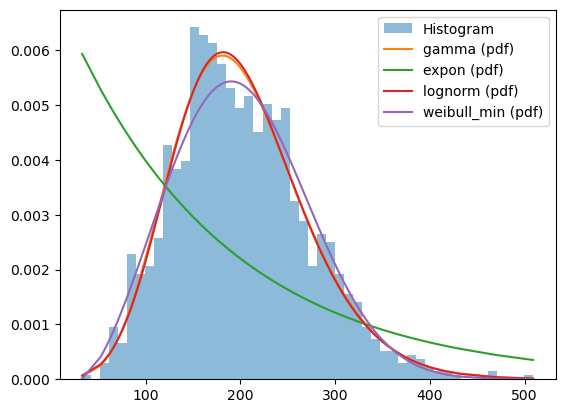

In [56]:
import matplotlib.pyplot as plt

df_d_plot = df_distr.sort_values(by="rain_sum")

plt.hist(df_d_plot["rain_sum"], bins=50, density=True, alpha=0.5, label='Histogram')
x = np.linspace(df_d_plot["rain_sum"].min(), df_distr["rain_sum"].max(), 100)

for distr in dist_names:
    plt.plot(df_d_plot["rain_sum"], df_d_plot[distr + "_pdf"], label=distr + ' (pdf)')

plt.legend()

In [59]:
ecdf_res = scs.ecdf(df_rain_sums["rain_sum_all"].dropna())
df_distr["ecdf"] = ecdf_res.cdf.evaluate(df_rain_sums["rain_sum_all"])

<Axes: xlabel='rain_sum'>

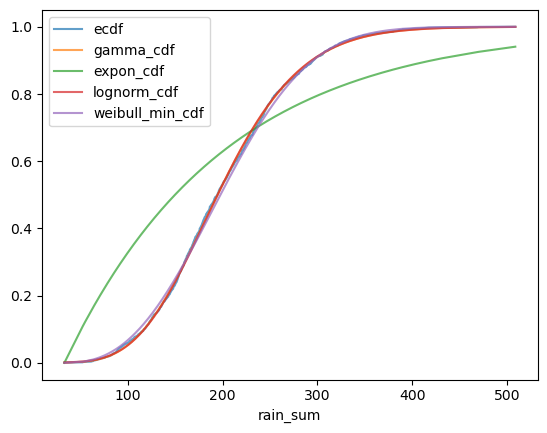

In [60]:
df_distr[["rain_sum", "ecdf"] + [d + "_cdf" for d in dist_names]].sort_values(by="rain_sum").plot(x="rain_sum", alpha=0.7)

In [61]:
df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf
date,,,,,,,,,,
1906-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1906-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1906-03-01,215.100,0.613861,0.005253,0.661012,0.002013,0.614711,0.005304,0.592951,0.005171,0.604357
1906-04-01,132.200,0.158297,0.004322,0.445441,0.003293,0.156292,0.004279,0.172776,0.004027,0.155306
1906-05-01,167.600,0.341633,0.005784,0.550565,0.002668,0.339628,0.005826,0.338731,0.005206,0.347154
...,...,...,...,...,...,...,...,...,...,...
2024-08-01,185.225,0.445171,0.005895,0.595220,0.002403,0.444145,0.005960,0.432810,0.005424,0.453268
2024-09-01,284.875,0.879442,0.002351,0.775991,0.001330,0.880744,0.002326,0.874382,0.002672,0.874209
2024-10-01,240.125,0.733164,0.004242,0.707816,0.001735,0.734869,0.004258,0.714156,0.004455,0.723120


In [62]:
# Calculate the squared differences (L2-norm) between the ECDF and each distribution's CDF
# In this way we can intuitively choose the best-matching one
distances = {}
for dist_name in dist_names:
    # Squared differences (L2-norm)
    squared_diff = (df_distr["ecdf"] - df_distr[dist_name + "_cdf"]) ** 2
    # Sum of squared differences (L2-norm distance)
    distances[dist_name] = squared_diff.sum()

best_fit = min(distances, key=distances.get)

print(distances)
print(best_fit)

{'gamma': 0.06168335495807602, 'expon': 43.61360727699537, 'lognorm': 0.07393879966143277, 'weibull_min': 0.2565614550556514}
gamma


In [63]:
# Apply inverse normal distribution to best-fit CDF
norm_ppf = scs.norm.ppf(df_distr[best_fit + "_cdf"])
norm_ppf[np.isinf(norm_ppf)] = np.nan

df_distr["spi"] = norm_ppf.copy()

df_distr

,rain_sum,gamma_cdf,gamma_pdf,expon_cdf,expon_pdf,lognorm_cdf,lognorm_pdf,weibull_min_cdf,weibull_min_pdf,ecdf,spi
date,,,,,,,,,,,
1906-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
1906-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN
1906-03-01,215.100,0.613861,0.005253,0.661012,0.002013,0.614711,0.005304,0.592951,0.005171,0.604357,0.289397
1906-04-01,132.200,0.158297,0.004322,0.445441,0.003293,0.156292,0.004279,0.172776,0.004027,0.155306,-1.001481
1906-05-01,167.600,0.341633,0.005784,0.550565,0.002668,0.339628,0.005826,0.338731,0.005206,0.347154,-0.408009
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-01,185.225,0.445171,0.005895,0.595220,0.002403,0.444145,0.005960,0.432810,0.005424,0.453268,-0.137872
2024-09-01,284.875,0.879442,0.002351,0.775991,0.001330,0.880744,0.002326,0.874382,0.002672,0.874209,1.172200
2024-10-01,240.125,0.733164,0.004242,0.707816,0.001735,0.734869,0.004258,0.714156,0.004455,0.723120,0.622410


<Axes: xlabel='date'>

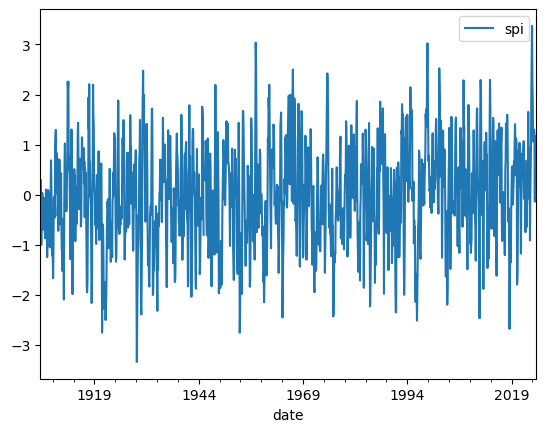

In [64]:
df_distr.reset_index().plot(x="date", y="spi")

Quote from WMO Report:
> A drought event occurs any time the SPI is continuously negative and reaches an intensity of -1.0 or less. The event ends when the SPI becomes positive. Each drought event, therefore, has a duration defined by its beginning and end, and an intensity for each month that the event continues. The positive sum of the SPI for all the months within a drought event can be termed the drought’s “magnitude”.


In [ ]:
# TODO: Analyze periods of drought from SPI-1, 3, 6, 12, and 36 perspectives
# TODO: (Also make sure the solution is flexible, allowing others to take different vals as well)

In [ ]:
# TODO: Run a workflow in which RH and EV24 are imputed separately,
# TODO: and then combined, fit to distr., which should give SPEI

In [119]:
# TODO: Mention existence of SPI/SPEI package for Python: https://github.com/e-baumer/standard_precip